## Hardware

ther are the same thing, but the language has stuck CPUS have cores. This is because *multiple cores are on the same chip*.

a processor has

- multiple cores; a core is a central processing unit
- and you might be able to run multiple hyperthreads per core
- hyperthreads are like co-routines in hardware.
- each core has its own registers and ALU
- typically all the cores on a cpu share a cache (there might be per core caches)
- and multiple cpus share memory

```
 Model Name:	MacBook Air
  Model Identifier:	MacBookAir6,2
  Processor Name:	Intel Core i7
  Processor Speed:	1.7 GHz
  Number of Processors:	1
  Total Number of Cores:	2
  L2 Cache (per Core):	256 KB
  L3 Cache:	4 MB
  Memory:	8 GB
```

But:

![](https://dl.dropboxusercontent.com/u/75194/4ht.png)

shows that I have 2 logical-cpus or hyperthreads per core.

```
➜  ~ sysctl hw.physicalcpu
hw.physicalcpu: 2
➜  ~ sysctl hw.logicalcpu
hw.logicalcpu: 4
```

In [1]:
import multiprocessing as mp
print(mp.cpu_count())

4


Hyperthreading: a core fetches and executes instructions from multiple locations. Wikipedia has a good explanation of Simultaneous multithreading, of which hyperthreading is an example:

>Simultaneous multithreading (SMT) is one of the two main implementations of multithreading, the other form being temporal multithreading. In temporal multithreading, only one thread of instructions can execute in any given pipeline stage at a time. In simultaneous multithreading, instructions from more than one thread can be executed in any given pipeline stage at a time. This is done without great changes to the basic processor architecture: the main additions needed are the ability to fetch instructions from multiple threads in a cycle, and a larger register file to hold data from multiple threads. The number of concurrent threads can be decided by the chip designers. Two concurrent threads per CPU core are common, but some processors support eight concurrent threads per core.



A hyper-threading aware OS realizes that processes ought not necessarily be scheduled first on contiguous logical cpus. Which processes, then, are scheduled on logically continuous cpus?

- if you are going to have cache line swapping between physical cores to the L3 cache, you will have bad performance. If you can fit inside L2 and reuse the cache, then those two should be scheduled on the same cache. If no sharing, then on different cores.
- logical cpus are useful for non-overlapping operations and lock-free data structures
- sometimes hyperthreading will slow down performance because the system scheduler may not be able to make the correct decisions




In [5]:
!sysctl -a | grep hw

hw.machine = x86_64
hw.model = MacBookAir6,2
hw.ncpu = 4
hw.byteorder = 1234
hw.physmem = 2147483648
hw.usermem = 632987648
hw.pagesize = 4096
hw.epoch = 0
hw.vectorunit = 1
hw.busfrequency = 100000000
hw.cpufrequency = 1700000000
hw.cachelinesize = 64
hw.l1icachesize = 32768
hw.l1dcachesize = 32768
hw.l2settings = 1
hw.l2cachesize = 262144
hw.l3settings = 1
hw.l3cachesize = 4194304
hw.tbfrequency = 1000000000
hw.memsize = 8589934592
hw.availcpu = 4
net.inet.ip.adj_clear_hwcksum: 0
net.link.generic.system.hwcksum_in_invalidated: 0
net.link.generic.system.hwcksum_dbg: 0
net.link.generic.system.hwcksum_dbg_mode: 0
net.link.generic.system.hwcksum_dbg_partial_forced: 0
net.link.generic.system.hwcksum_dbg_partial_forced_bytes: 0
net.link.generic.system.hwcksum_dbg_partial_rxoff_forced: 0
net.link.generic.system.hwcksum_dbg_partial_rxoff_adj: 0
net.link.generic.system.hwcksum_dbg_verified: 0
net.link.generic.system.hwcksum_dbg_bad_cksum: 0
net.link.generic.system.hwcksum_dbg_bad_rxoff: 0
net

## Julia

Not that one: ![](http://cdn1.techworld.com/cmsdata/slideshow/3621455/Julia_programming_language_image_Julia_thumb800.jpg)

Nor that one either:

![](http://images2.fanpop.com/images/photos/7000000/Giulia-e-Giulia-kathleen-turner-7000370-640-424.jpg)

rather this:

![](http://3.bp.blogspot.com/-xOjdGq84uaw/UAJsSjzt5FI/AAAAAAAAAD4/C_-Zt3nOytA/s1600/julia.png)

In [66]:
from collections import namedtuple
Box = namedtuple("Box", "x1 x2 y1 y2")
bounds = Box(-1.8, 1.8, -1.8, 1.8)
focus=complex(-0.62772, -.42193)
gridsize=1000
iters=300
focus

(-0.62772-0.42193j)

In [67]:
def setup_grid(gridsize, box):
    xstep = (box.x2 - box.x1)/(gridsize - 1.0)
    ystep = (box.y2 - box.y1)/(gridsize - 1.0)
    xs = (box.x1+ i* xstep for i in range(gridsize))
    zs=[]
    for x in xs:
        ys = (box.y1+ i* ystep for i in range(gridsize))
        for y in ys:
            zs.append(complex(x,y))
    return zs

In [68]:
def zts1(maxiter, zs, c): 
    output = [0] * len(zs)
    for i,z in enumerate(zs):
        n=0
        while abs(z) < 2 and n < maxiter:
            z=z*z+c
            n+=1 
            output[i] = n
    return output

In [69]:
def run1():
    zs = setup_grid(gridsize, bounds)
    out = zts1(iters, zs, focus)
    return zs, out

In [70]:
zs, out = run1()

In [71]:
len(zs)

1000000

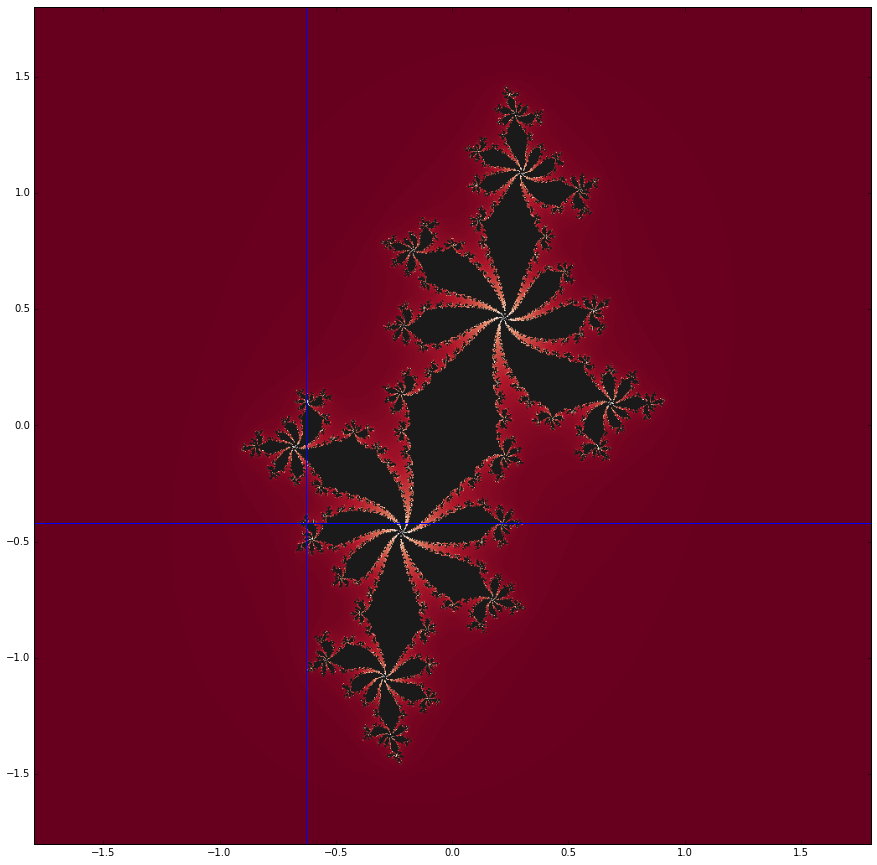

In [81]:
%matplotlib inline
mat = np.zeros((gridsize, gridsize))
k = 0
for i in range(gridsize):
    for j in range(gridsize):
        mat[i,gridsize -1 - j] = out[k]
        k += 1
fig = plt.figure(figsize=(15,15))
plt.imshow(mat, cmap="RdGy", extent=bounds)
plt.axvline(focus.real)
plt.axhline(focus.imag)

In [82]:
%timeit -r 1 -n 5 run1()

5 loops, best of 1: 12.1 s per loop


## Profiling

- Aim: what is running slow
- or in general consuming resources

Our stock will be `%timeit`. It will be the first weapon in our armory. But really we want to know at a much finer grain, which line, or which function is eating resources..

Make a hypothesis about what is running slow...

### Which function? `cprofile`.

In [95]:
import cProfile as profile
import pstats, io
pr=profile.Profile()
pr.enable()
run1()
pr.disable()
ps = pstats.Stats(pr)

Look at `cumtime`. Also, for fun and sanity check, one can make sure that `ncalls` is what one expects

In [96]:
ps.sort_stats("cumulative")
ps.print_stats()

         36182582 function calls in 16.605 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   16.605    8.303 //anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3036(run_code)
        2    0.000    0.000   16.605    8.302 {built-in method builtins.exec}
        1    0.018    0.018   16.605   16.605 <ipython-input-95-0442cb6ac330>:5(<module>)
        1    0.000    0.000   16.587   16.587 <ipython-input-69-3c005833f8a2>:1(run1)
        1   13.220   13.220   15.755   15.755 <ipython-input-68-ad42f7acf96e>:1(zts1)
 34180558    2.535    0.000    2.535    0.000 {built-in method builtins.abs}
        1    0.479    0.479    0.832    0.832 <ipython-input-67-ce8334286fd4>:1(setup_grid)
  1001000    0.289    0.000    0.289    0.000 <ipython-input-67-ce8334286fd4>:7(<genexpr>)
  1000000    0.064    0.000    0.064    0.000 {method 'append' of 'list' objects}
     1001    0.000 

In [97]:
ps.print_callers()

   Ordered by: cumulative time

Function                                                                                                was called by...
                                                                                                            ncalls  tottime  cumtime
//anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3036(run_code)        <- 
{built-in method builtins.exec}                                                                         <-       2    0.000   16.605  //anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3036(run_code)
<ipython-input-95-0442cb6ac330>:5(<module>)                                                             <-       1    0.018   16.605  {built-in method builtins.exec}
<ipython-input-69-3c005833f8a2>:1(run1)                                                                 <-       1    0.000   16.587  <ipython-input-95-0442cb6ac330>:5(<module>)
<ipython-input-68-ad42f7acf96e>

In [98]:
ps.print_callees()

   Ordered by: cumulative time

Function                                                                                                called...
                                                                                                            ncalls  tottime  cumtime
//anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3036(run_code)        ->       2    0.000    0.000  //anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/hooks.py:127(__call__)
                                                                                                                 2    0.000    0.000  //anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:1136(user_global_ns)
                                                                                                                 2    0.000    0.000  //anaconda/envs/py35/lib/python3.5/site-packages/IPython/utils/ipstruct.py:125(__getattr__)
                                       

Ok, so `zts1` is slow..but where?

### Line based profiling..

`pip install line_profiler`

We put the `@profile` macro on the function for which we want line-by-line profiling. Typically, this is the most expensive function we found above.

In [99]:
%%file julia1.py

from collections import namedtuple
Box = namedtuple("Box", "x1 x2 y1 y2")
bounds = Box(-1.8, 1.8, -1.8, 1.8)
focus=complex(-0.62772, -.42193)
gridsize=1000
iters=300

def setup_grid(gridsize, box):
    xstep = (box.x2 - box.x1)/(gridsize - 1.0)
    ystep = (box.y2 - box.y1)/(gridsize - 1.0)
    xs = (box.x1+ i* xstep for i in range(gridsize))
    zs=[]
    for x in xs:
        ys = (box.y1+ i* ystep for i in range(gridsize))
        for y in ys:
            zs.append(complex(x,y))
    return zs

@profile
def zts1(maxiter, zs, c): 
    output = [0] * len(zs)
    for i,z in enumerate(zs):
        n=0
        while abs(z) < 2 and n < maxiter:
            z=z*z+c
            n+=1 
            output[i] = n
    return output

def run1():
    zs = setup_grid(gridsize, bounds)
    out = zts1(iters, zs, focus)
    return zs, out

if __name__=='__main__':
    run1()

Writing julia1.py


In [102]:
!kernprof -l -v julia1.py

Wrote profile results to julia1.py.lprof
Timer unit: 1e-06 s

Total time: 71.3915 s
File: julia1.py
Function: zts1 at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           @profile
    21                                           def zts1(maxiter, zs, c): 
    22         1        10075  10075.0      0.0      output = [0] * len(zs)
    23   1000001       521017      0.5      0.7      for i,z in enumerate(zs):
    24   1000000       428800      0.4      0.6          n=0
    25  34180558     21760200      0.6     30.5          while abs(z) < 2 and n < maxiter:
    26  33180558     17213044      0.5     24.1              z=z*z+c
    27  33180558     15721024      0.5     22.0              n+=1 
    28  33180558     15737324      0.5     22.0              output[i] = n
    29         1            0      0.0      0.0      return output



you want to see the `time` column.

Notice that
- the while is expensive
- even `n+=1` is expensive
- the `z` update is expensive

can you catch the bug in our code? we fix it below. Sometimes extra function calls can point tp a bug...

In [108]:
%%file julia2.py

from collections import namedtuple
Box = namedtuple("Box", "x1 x2 y1 y2")
bounds = Box(-1.8, 1.8, -1.8, 1.8)
focus=complex(-0.62772, -.42193)
gridsize=1000
iters=300

def setup_grid(gridsize, box):
    xstep = (box.x2 - box.x1)/(gridsize - 1.0)
    ystep = (box.y2 - box.y1)/(gridsize - 1.0)
    xs = (box.x1+ i* xstep for i in range(gridsize))
    zs=[]
    for x in xs:
        ys = (box.y1+ i* ystep for i in range(gridsize))
        for y in ys:
            zs.append(complex(x,y))
    return zs

@profile
def zts1(maxiter, zs, c): 
    output = [0] * len(zs)
    for i,z in enumerate(zs):
        n=0
        while abs(z) < 2 and n < maxiter:
            z=z*z+c
            n+=1 
        output[i] = n
    return output

def run1():
    zs = setup_grid(gridsize, bounds)
    out = zts1(iters, zs, focus)
    return zs, out

if __name__=='__main__':
    run1()

Overwriting julia2.py


In [109]:
!kernprof -l -v julia2.py

Wrote profile results to julia2.py.lprof
Timer unit: 1e-06 s

Total time: 61.536 s
File: julia2.py
Function: zts1 at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           @profile
    21                                           def zts1(maxiter, zs, c): 
    22         1         5293   5293.0      0.0      output = [0] * len(zs)
    23   1000001       588859      0.6      1.0      for i,z in enumerate(zs):
    24   1000000       464926      0.5      0.8          n=0
    25  34180558     23697702      0.7     38.5          while abs(z) < 2 and n < maxiter:
    26  33180558     19090847      0.6     31.0              z=z*z+c
    27  33180558     17150285      0.5     27.9              n+=1 
    28   1000000       538090      0.5      0.9          output[i] = n
    29         1            0      0.0      0.0      return output



Ok, so we gained some seconds. Not big, but not bad..

In [112]:
from collections import namedtuple
Box = namedtuple("Box", "x1 x2 y1 y2")
bounds = Box(-1.8, 1.8, -1.8, 1.8)
focus=complex(-0.62772, -.42193)
gridsize=1000
iters=300

def setup_grid(gridsize, box):
    xstep = (box.x2 - box.x1)/(gridsize - 1.0)
    ystep = (box.y2 - box.y1)/(gridsize - 1.0)
    xs = (box.x1+ i* xstep for i in range(gridsize))
    zs=[]
    for x in xs:
        ys = (box.y1+ i* ystep for i in range(gridsize))
        for y in ys:
            zs.append(complex(x,y))
    return zs

def zts1(maxiter, zs, c): 
    output = [0] * len(zs)
    for i,z in enumerate(zs):
        n=0
        while abs(z) < 2 and n < maxiter:
            z=z*z+c
            n+=1 
        output[i] = n
    return output

def run1():
    zs = setup_grid(gridsize, bounds)
    out = zts1(iters, zs, focus)
    return zs, out

In [113]:
%timeit -r 1 -n 5 run1()

5 loops, best of 1: 10.9 s per loop


Notice the profile-based and timeit-based times are different. This is as profiling adds overhead. Dont trust the absolute profiling times, but you are looking to see the relative times.

Lets switch the order in the while, as the absolute-value comparision sounds complicated...

In [119]:
from collections import namedtuple
Box = namedtuple("Box", "x1 x2 y1 y2")
bounds = Box(-1.8, 1.8, -1.8, 1.8)
focus=complex(-0.62772, -.42193)
gridsize=1000
iters=300

def setup_grid(gridsize, box):
    xstep = (box.x2 - box.x1)/(gridsize - 1.0)
    ystep = (box.y2 - box.y1)/(gridsize - 1.0)
    xs = (box.x1+ i* xstep for i in range(gridsize))
    zs=[]
    for x in xs:
        ys = (box.y1+ i* ystep for i in range(gridsize))
        for y in ys:
            zs.append(complex(x,y))
    return zs

def zts1(maxiter, zs, c): 
    output = [0] * len(zs)
    for i,z in enumerate(zs):
        n=0
        while n < maxiter and abs(z) < 2:
            z=z*z+c
            n+=1 
        output[i] = n
    return output

def run1():
    zs = setup_grid(gridsize, bounds)
    out = zts1(iters, zs, focus)
    return zs, out

In [120]:
%timeit -r 1 -n 5 run1()

5 loops, best of 1: 10.4 s per loop


In [136]:
%%file julia3.py

from collections import namedtuple
Box = namedtuple("Box", "x1 x2 y1 y2")
bounds = Box(-1.8, 1.8, -1.8, 1.8)
focus=complex(-0.62772, -.42193)
gridsize=1000
iters=300

def setup_grid(gridsize, box):
    xstep = (box.x2 - box.x1)/(gridsize - 1.0)
    ystep = (box.y2 - box.y1)/(gridsize - 1.0)
    xs = (box.x1+ i* xstep for i in range(gridsize))
    zs=[]
    for x in xs:
        ys = (box.y1+ i* ystep for i in range(gridsize))
        for y in ys:
            zs.append(complex(x,y))
    return zs

@profile
def zts1(maxiter, zs, c): 
    output = [0] * len(zs)
    for i,z in enumerate(zs):
        n=0
        while n < maxiter and abs(z) < 2:
            z=z*z+c
            n+=1 
        output[i] = n
    return output

def run1():
    zs = setup_grid(gridsize, bounds)
    out = zts1(iters, zs, focus)
    return zs, out

if __name__=='__main__':
    run1()

Overwriting julia3.py


Lets rerun the line by line profiler

In [137]:
!kernprof -l -v julia3.py

Wrote profile results to julia3.py.lprof
Timer unit: 1e-06 s

Total time: 57.4056 s
File: julia3.py
Function: zts1 at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           @profile
    21                                           def zts1(maxiter, zs, c): 
    22         1        17883  17883.0      0.0      output = [0] * len(zs)
    23   1000001       552009      0.6      1.0      for i,z in enumerate(zs):
    24   1000000       456202      0.5      0.8          n=0
    25  34180558     22106558      0.6     38.5          while n < maxiter and abs(z) < 2:
    26  33180558     17622721      0.5     30.7              z=z*z+c
    27  33180558     16129586      0.5     28.1              n+=1 
    28   1000000       520684      0.5      0.9          output[i] = n
    29         1            2      2.0      0.0      return output

